# Setup Imports

In [1]:
# Setup Essentials
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Models
import torch.nn as nn
import torch.nn.functional as F

# Optimization Functions
import torch.optim as optim

In [2]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define data transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),      # Randomly rotate the image by a maximum of 10 degrees
    # transforms.RandomCrop(32, padding=2),  # Randomly crop the image with padding of 2 pixels
    transforms.ToTensor(),              # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image pixel values
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize Data

In [3]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv4.weight)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(0.3)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv5.weight)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv6.weight)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout2d(0.4)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        nn.init.kaiming_uniform_(self.fc1.weight)
        self.bn7 = nn.BatchNorm1d(128)
        self.drop4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop1(self.pool1(x))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.drop2(self.pool2(x))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.drop3(self.pool3(x))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.drop4(x)
        x = self.fc2(x)
        return x


# # Make use of GPU if possible
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device=\"{device}\"")
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device="cuda"


# Train Model

In [6]:
losses = []

for epoch in range(400):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
            # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10000:.3f}')
            # running_loss = 0.0

    print(f'epoch={epoch + 1} loss={running_loss}')
    losses.append(running_loss)
    
    # if epoch > 9:
    #     if losses[epoch-10] - (running_loss) < 0.01:
    #         break


print('Finished Training')

epoch=1 loss=3102.5455973148346
epoch=2 loss=2707.4954649209976
epoch=3 loss=2564.0861209630966
epoch=4 loss=2437.1656683683395
epoch=5 loss=2341.81807243824
epoch=6 loss=2243.132687866688
epoch=7 loss=2163.024545609951
epoch=8 loss=2092.761696398258
epoch=9 loss=2012.55682605505
epoch=10 loss=1950.7763873934746
epoch=11 loss=1898.781487107277
epoch=12 loss=1838.7401576638222
epoch=13 loss=1787.9801351428032
epoch=14 loss=1758.887875020504
epoch=15 loss=1711.3090012073517
epoch=16 loss=1682.074581503868
epoch=17 loss=1645.8420303463936
epoch=18 loss=1617.1569376587868
epoch=19 loss=1593.3388969898224
epoch=20 loss=1568.0121850967407
epoch=21 loss=1540.5571097433567
epoch=22 loss=1520.9868034124374
epoch=23 loss=1495.373996168375
epoch=24 loss=1485.0793501138687
epoch=25 loss=1459.1228621900082
epoch=26 loss=1432.677013874054
epoch=27 loss=1421.1830591261387
epoch=28 loss=1410.7660204470158
epoch=29 loss=1393.042553693056
epoch=30 loss=1376.345437169075
epoch=31 loss=1361.5345396101475


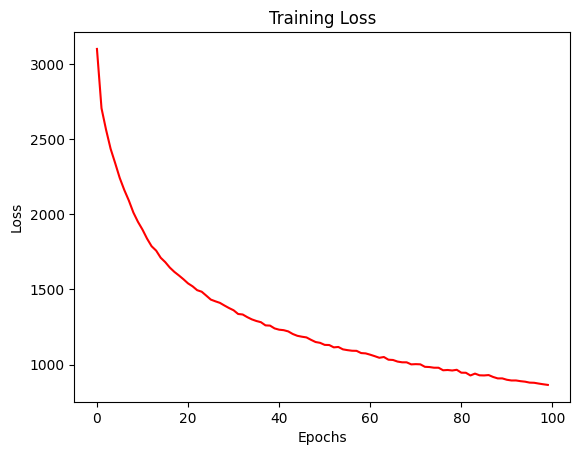

In [7]:
plt.plot(losses, 'r')  # Plotting the loss values with red color ('r')
plt.xlabel('Epochs')  # Labeling the x-axis as 'Epochs'
plt.ylabel('Loss')  # Labeling the y-axis as 'Loss'
plt.title('Training Loss')  # Adding a title to the plot
plt.show()  # Displaying the plot

# Save Model

In [8]:
PATH = 'models/cifar_cnn_cq.pth'
torch.save(net.state_dict(), PATH)

In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Check Accuracy

## Overall Accuracy

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

Accuracy of the network on the 10000 test images: 76%


## Accuracy Per Class

In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.5 %
Accuracy for class: car   is 87.9 %
Accuracy for class: bird  is 66.3 %
Accuracy for class: cat   is 60.9 %
Accuracy for class: deer  is 76.1 %
Accuracy for class: dog   is 67.0 %
Accuracy for class: frog  is 81.5 %
Accuracy for class: horse is 82.7 %
Accuracy for class: ship  is 87.2 %
Accuracy for class: truck is 86.3 %


In [12]:
del dataiter

# Code For Loading Learned Weights

In [13]:
%%script false --no-raise-error # Disables the cell
net = Net()
net.load_state_dict(torch.load(PATH))

Couldn't find program: 'false'
